In [1]:
#BEGIN random forest
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = np.loadtxt('feature_data.csv', delimiter=',')
y = np.loadtxt('class_data.csv', delimiter=',')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
total = 0
for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]: total +=1 
        
print("Accuracy: {}".format(total / len(y_pred)))



Accuracy: 0.6009615384615384


In [18]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
def show_decision_surface(model, X, y, ax=None):
    """
    Helper function to visualize the decision surface of the trained model
    :param model with predict method
    :return: None
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x_grid, y_grid = np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1)
    xx, yy = np.meshgrid(x_grid, y_grid)
    r1, r2 = xx.reshape(-1, 1), yy.reshape(-1, 1)
    grid = np.hstack((r1, r2))
    y_hat = model.predict(grid).reshape(-1, )
    zz = y_hat.reshape(xx.shape)

    if ax is None:
        plt.contourf(xx, yy, zz, cmap='PiYG')
        plt.scatter(X[:, 0], X[:, 1], c=y)
        plt.show()
    else:
        ax.contourf(xx, yy, zz, cmap='PiYG')
        ax.scatter(X[:, 0], X[:, 1], c=y)


In [3]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
print("Accuracy: "+str((y_test != y_pred).sum()/X_test.shape[0]))

Number of mislabeled points out of a total 208 points : 94
Accuracy: 0.4519230769230769


In [4]:
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
"""
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua import QuantumInstance
"""
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms import QSVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import svm

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [5]:
def confusion_matrix(y_pred, y_true, percent = True, display = False, labels = None):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    vals = np.unique(y_true)
    vals[::-1].sort() # largest values show up first in confusion matrix
    n = len(vals)
    mat = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            mat[i, j] = sum((y_true == vals[i]) & (y_pred == vals[j]))
    if percent:
        mat = mat/np.sum(mat, axis = 1, keepdims = True)
    
    if display:
        if labels is None:
            labels = vals
        _, ax = plt.subplots()
        plt.ylabel("actual")
        plt.xlabel("predicted")
        ax.matshow(mat, cmap=plt.cm.Blues)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.xaxis.set_ticks(range(n))
        ax.yaxis.set_ticks(range(n))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        for i in range(mat.shape[0]):
            for j in range(mat.shape[0]):
                ax.text(i, j, str(mat[j,i]), va='center', ha='center')
        plt.show()
    return mat

In [6]:
def ROC(y_train_score1, y_test_score1, y_train, y_test):
    falsePos1, truePos1, _ = roc_curve(y_train, y_train_score1)
    roc_auc1 = auc(falsePos1, truePos1)

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
    ax1.plot(falsePos1, truePos1, label='SVM $\gamma = 5$', color='b')
    ax1.set_title('Training Data')

    falsePos2, truePos2, _ = roc_curve(y_test, y_test_score1)
    roc_auc1 = auc(falsePos2, truePos2)
    ax2.plot(falsePos2, truePos2, label='SVM $\gamma = 5$', color='b')

    ax2.set_title('Test Data')

    for ax in fig.axes:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([-0.05, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right")

In [16]:
svm1 = svm.SVC(C = 8, kernel = "rbf", gamma = .08)
start_time = time.time()
svm1.fit(X_train, y_train) # train
train_time = time.time() - start_time
y1_pred = svm1.predict(X_test) #predict
test_time = time.time() - start_time - train_time
print ("Direct kernel set classical SVM")
print ("Training time:{0}".format(train_time) + "[sec]")
print ("Test time:{0}".format(test_time) + "[sec]")
print("Svm accuracy: "+str(svm1.score(X_test,y_test)))

Direct kernel set classical SVM
Training time:0.007067441940307617[sec]
Test time:0.0020029544830322266[sec]
Svm accuracy: 0.6009615384615384


In [19]:
svm1 = svm.SVC(kernel = "linear")
start_time = time.time()
svm1.fit(X_train, y_train) # train
train_time = time.time() - start_time
y1_pred = svm1.predict(X_test) #predict
test_time = time.time() - start_time - train_time
print ("Direct kernel set classical SVM")
print ("Training time:{0}".format(train_time) + "[sec]")
print ("Test time:{0}".format(test_time) + "[sec]")
print("Svm accuracy: "+str(svm1.score(X_test,y_test)))

Direct kernel set classical SVM
Training time:0.006704568862915039[sec]
Test time:0.0[sec]
Svm accuracy: 0.5961538461538461


In [9]:
def PolynomialKernel(c, p):
    
    def PolynomialK(x1, x2):
        """
        Compute the kernel matrix.
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = (x1[i].x2[j] + c)^p
        """
        # Workspace 2.3
        K = np.zeros((x1.shape[0], x2.shape[0]))
        #BEGIN 
        # code here
        for i in range(0,len(x1)):
            for j in range(0,len(x2)):
                K[i][j] = (np.dot(x1[i],x2[j])+c)**p
        #END
        return K
    return PolynomialK

svm1 = svm.SVC(kernel=PolynomialKernel(c=1,p=2))
start_time = time.time()
svm1.fit(X_train, y_train) # train
train_time = time.time() - start_time
y1_pred = svm1.predict(X_test) #predict
test_time = time.time() - start_time - train_time
print ("Direct kernel set classical SVM")
print ("Training time:{0}".format(train_time) + "[sec]")
print ("Test time:{0}".format(test_time) + "[sec]")
print("Svm accuracy: "+str(svm1.score(X_test,y_test)))

Direct kernel set classical SVM
Training time:0.528923749923706[sec]
Test time:0.20765042304992676[sec]
Svm accuracy: 0.5721153846153846


Direct kernel set classical SVM


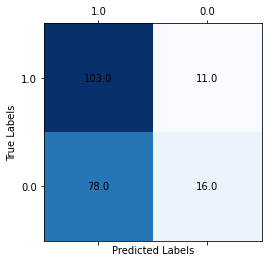

array([[103.,  11.],
       [ 78.,  16.]])

In [10]:
print ("Direct kernel set classical SVM")
confusion_matrix(y1_pred, y_test, False, True)

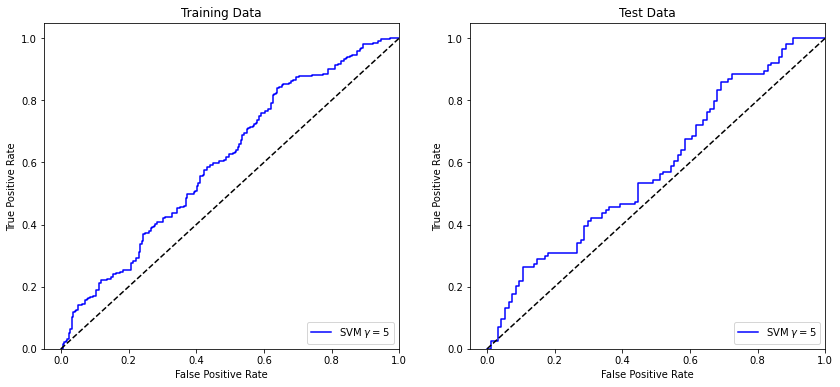

In [11]:
y_train_score1 = svm1.decision_function(X_train)
y_test_score1 = svm1.decision_function(X_test)

ROC(y_train_score1, y_test_score1, y_train, y_test)